In [1]:
from clearml.task import Task
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style("whitegrid")
sns.set_palette("muted")

# Get tasks

In [2]:
tasks = Task.get_tasks(project_name="lie-pose-net", task_filter={"system_tags": ["-archived"]})

In [3]:
completed_tasks = [x for x in tasks if x.status == "completed" or x.status == "published"]

In [4]:
completed_tasks[0].get_parameters()

{'General/activation': 'tanh',
 'General/batch_size': '64',
 'General/bias': 'True',
 'General/check_val_every_n_epoch': '2',
 'General/checkpoint_every_n_val_epochs': '10',
 'General/criterion/name': 'SE3Criterion',
 'General/criterion/rotation_koef': '-3.0',
 'General/criterion/translation_koef': '-3.0',
 'General/data_path': '/media/mikhail/Data3T/7scenes',
 'General/drop_rate': '0',
 'General/feature_dimension': '2048',
 'General/feature_extractor/pretrained': 'True',
 'General/gpus': '1',
 'General/image_size': '256',
 'General/max_epochs': '100',
 'General/name': 'PoseNet',
 'General/num_workers': '4',
 'General/optimizer/betas': '0.9 0.999',
 'General/optimizer/lr': '0.0001',
 'General/optimizer/weight_decay': '0.0005',
 'General/pretrained': 'True',
 'General/scene': 'fire',
 'General/scheduler/gamma': '0.5',
 'General/scheduler/step_size': '20',
 'General/use_test': 'True'}

In [5]:
completed_tasks[0].get_last_scalar_metrics()

{'hp_metric': {'hp_metric': {'last': -1.0, 'min': -1.0, 'max': -1.0}},
 'epoch': {'epoch': {'last': 99.0, 'min': 1.0, 'max': 99.0}},
 'train_loss': {'train_loss': {'last': -9.336409,
   'min': -9.386719,
   'max': -8.17259}},
 'median_position_error': {'median_position_error': {'last': 0.35012203,
   'min': 0.32368505,
   'max': 0.36899588}},
 'val_loss': {'val_loss': {'last': -5.30872,
   'min': -5.426328,
   'max': -4.694355}},
 'median_rotation_error': {'median_rotation_error': {'last': 12.969347,
   'min': 11.642302,
   'max': 15.226498}},
 'position_error': {'position_error': {'last': 0.37688214,
   'min': 0.37303966,
   'max': 0.41400138}},
 'rotation_error': {'rotation_error': {'last': 17.524416,
   'min': 16.719898,
   'max': 20.259058}},
 ':monitor:machine': {'network_rx_mbs': {'last': 0.007,
   'min': 0.004,
   'max': 1.212},
  'io_read_mbs': {'last': 0.001, 'min': 0.0, 'max': 111.045},
  'io_write_mbs': {'last': 0.646, 'min': 0.216, 'max': 9.437},
  'memory_free_gb': {'last'

# Analyse lie pose net

In [6]:
task_dict = {x.id: x for x in completed_tasks}

In [7]:
parameters = [x.get_parameters() for x in completed_tasks]
task_data = pd.DataFrame({
    "id": [x.id for x in completed_tasks],
    "criterion": [x.get_parameters()["General/criterion/name"] for x in completed_tasks],
    "epoch": [x.get_last_scalar_metrics()["epoch"]["epoch"]["last"] for x in completed_tasks],
    "tags": [x.get_tags() for x in completed_tasks],
    "scene": [x.get_parameters()["General/scene"] for x in completed_tasks],
    "loss_type": [x.get("General/criterion/loss_type", "l2") for x in parameters]
})

In [8]:
task_data

,id,criterion,epoch,tags,scene,loss_type
0,709cb7f341b74cf4b70c778465f6f1d4,SE3Criterion,99.0,[good],fire,l2
1,7311ce5ca25d4149b538ea7c2787af31,SE3Criterion,99.0,[good],chess,l2
2,2ca30c315011418688b544ac7faab15e,SE3Criterion,99.0,[good],heads,l2
3,72de21bc9cb9406eac80815afc96e461,SE3Criterion,99.0,[good],office,l2
4,a5fa8425e9ff41fcb262fc4b4442459b,SE3Criterion,99.0,[],redkitchen,l2
5,88d05e64f59447c7a066b3549a872022,SE3Criterion,99.0,[good],pumpkin,l2
6,15b63a4f6dbb4019893752574112bb65,SE3Criterion,99.0,[good],stairs,l2
7,21a1398c2ef34f48a80697012e71f77a,PoseNetCriterion,99.0,[good],fire,l2
8,75910c48878e4f00a86e31323641f836,PoseNetCriterion,99.0,[good],stairs,l2
9,9ea1ba38216e408987aecdfbdf950ae6,PoseNetCriterion,99.0,[good],chess,l2


In [9]:
def filter_task_data(data):
    indexes = data["epoch"] >= 99
    indexes &= (data["criterion"] == "SE3Criterion") | (data["criterion"] == "PoseNetCriterion") | (data["criterion"] == "SimpleSE3Criterion")
    indexes &= ["good" in x for x in data["tags"]]
    return data[indexes]

In [10]:
filtred_task_data = filter_task_data(task_data)
filtred_task_data["criterion"] = [x["criterion"]+" "+x["loss_type"] for x in filtred_task_data.iloc()]
filtred_task_data

/tmp/ipykernel_1131464/3465479947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtred_task_data["criterion"] = [x["criterion"]+" "+x["loss_type"] for x in filtred_task_data.iloc()]


,id,criterion,epoch,tags,scene,loss_type
0,709cb7f341b74cf4b70c778465f6f1d4,SE3Criterion l2,99.0,[good],fire,l2
1,7311ce5ca25d4149b538ea7c2787af31,SE3Criterion l2,99.0,[good],chess,l2
2,2ca30c315011418688b544ac7faab15e,SE3Criterion l2,99.0,[good],heads,l2
3,72de21bc9cb9406eac80815afc96e461,SE3Criterion l2,99.0,[good],office,l2
5,88d05e64f59447c7a066b3549a872022,SE3Criterion l2,99.0,[good],pumpkin,l2
6,15b63a4f6dbb4019893752574112bb65,SE3Criterion l2,99.0,[good],stairs,l2
7,21a1398c2ef34f48a80697012e71f77a,PoseNetCriterion l2,99.0,[good],fire,l2
8,75910c48878e4f00a86e31323641f836,PoseNetCriterion l2,99.0,[good],stairs,l2
9,9ea1ba38216e408987aecdfbdf950ae6,PoseNetCriterion l2,99.0,[good],chess,l2
10,44d9030cf4ca45f5a8aa98307806f505,PoseNetCriterion l2,99.0,[good],pumpkin,l2


In [11]:
def get_metric_data(scalars, metric):
    data = pd.DataFrame({
        metric: scalars[metric][metric]["y"], 
        "iteration": scalars[metric][metric]["x"]
    }).set_index("iteration")
    return data

def get_several_metric_data(scalars, metrics):
    data = get_metric_data(scalars, metrics[0])
    for metric in metrics[1:]:
        data = data.join(get_metric_data(scalars, metric))
    return data

def add_column(data, column, value):
    data_length = len(data.index)
    data[column] = pd.Series([value for _ in range(data_length)])
    return data

In [12]:
experiment_data = pd.DataFrame()
for task_row in filtred_task_data.iloc:
    task = task_dict[task_row.id]
    reported_scalars = task.get_reported_scalars()
    data = get_several_metric_data(reported_scalars, ["epoch", "median_position_error", 
                                                                 "median_rotation_error", "val_loss"])
    data = data[~data.isnull().any(axis=1)].reset_index()
    data = add_column(data, "scene", task_row.scene)
    data = add_column(data, "criterion", task_row.criterion)
    data = add_column(data, "id", task_row.criterion)
    experiment_data = experiment_data.append(data)

<AxesSubplot:xlabel='epoch', ylabel='median_position_error'>

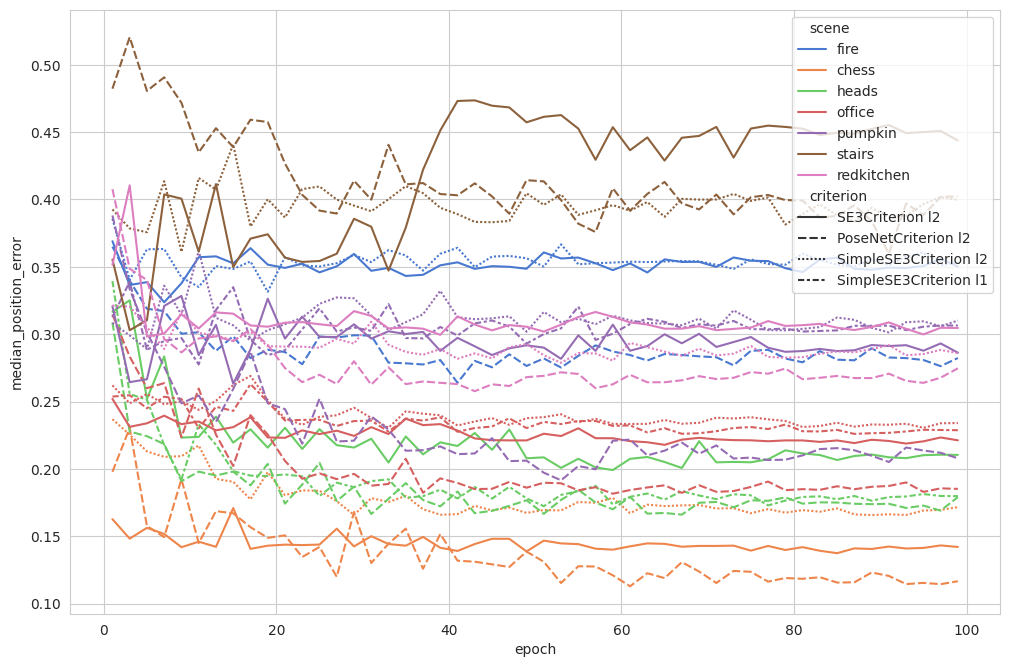

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
sns.lineplot(data=experiment_data, x="epoch", y="median_position_error", ax=ax, hue="scene", style="criterion")

<AxesSubplot:xlabel='epoch', ylabel='median_rotation_error'>

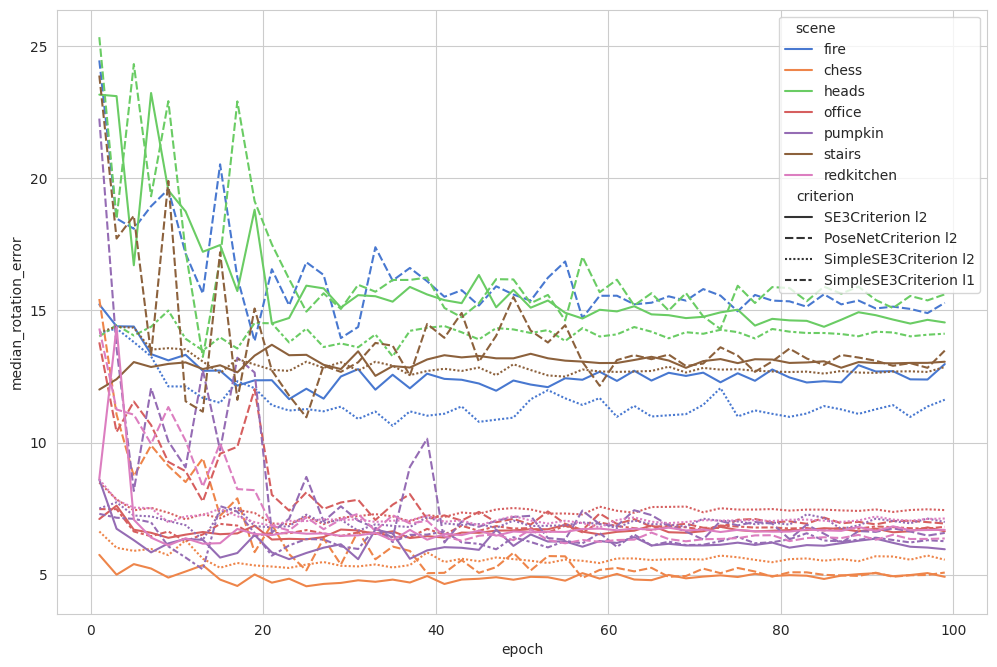

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
sns.lineplot(data=experiment_data, x="epoch", y="median_rotation_error", ax=ax, hue="scene", style="criterion")

<AxesSubplot:xlabel='epoch', ylabel='median_position_error'>

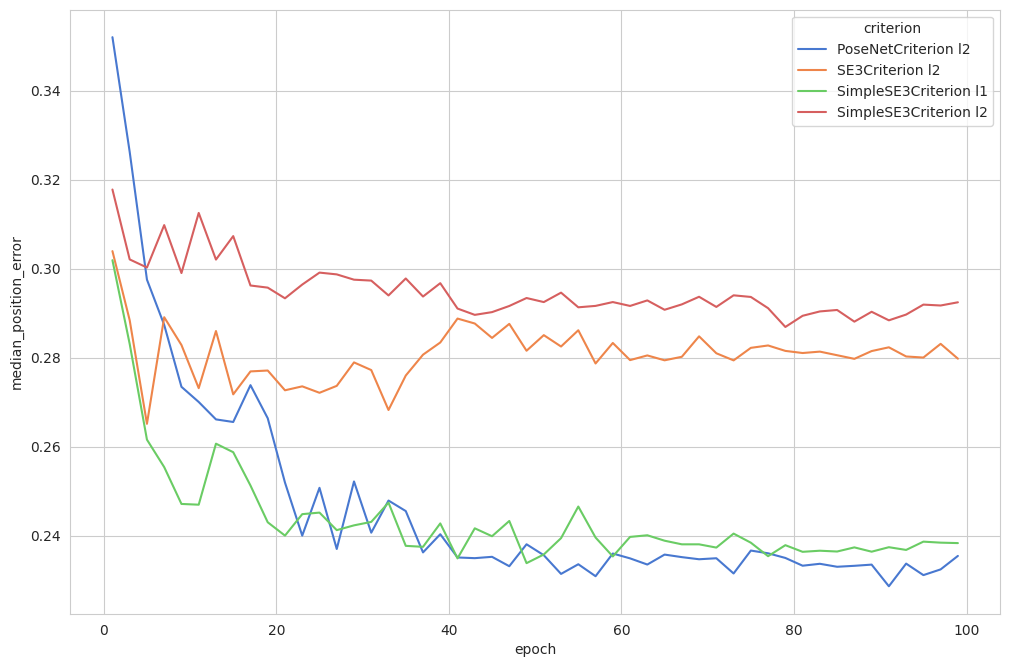

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
mean_trajectory_data = experiment_data.pivot_table(index=["epoch", "criterion"], values=["median_rotation_error", 
                                                                      "median_position_error"])
sns.lineplot(data=mean_trajectory_data, x="epoch", y="median_position_error", ax=ax, hue="criterion")

<AxesSubplot:xlabel='epoch', ylabel='median_rotation_error'>

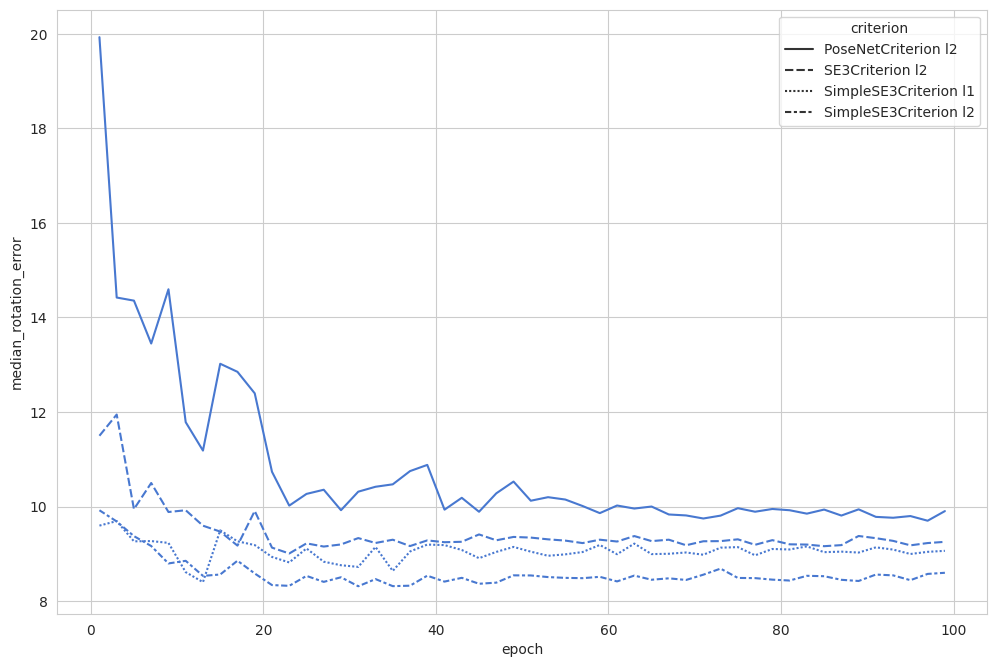

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
sns.lineplot(data=mean_trajectory_data, x="epoch", y="median_rotation_error", ax=ax, style="criterion")

<AxesSubplot:xlabel='epoch', ylabel='val_loss'>

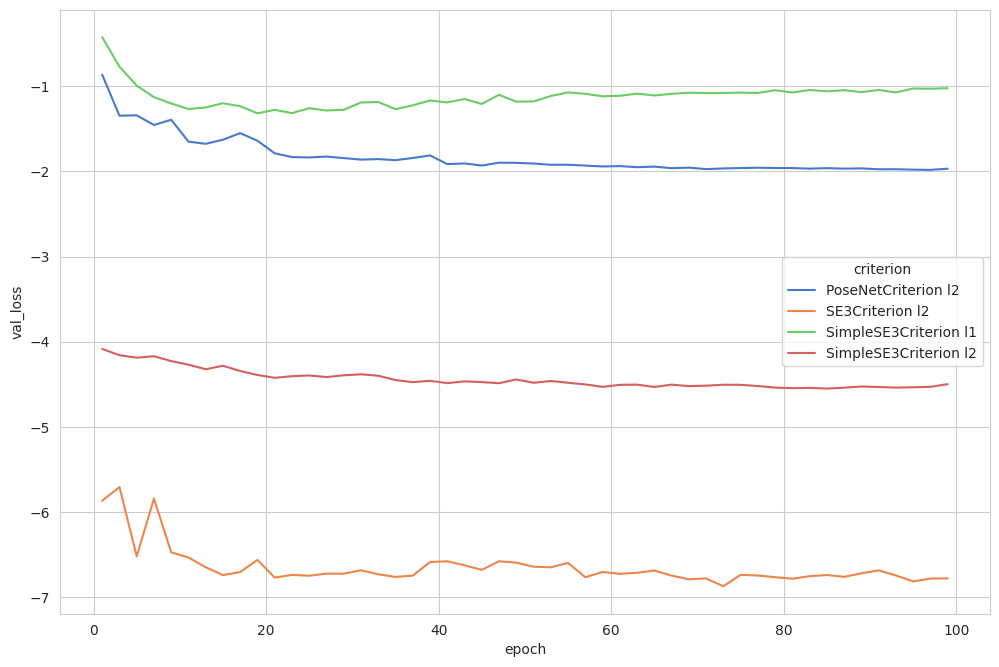

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
mean_trajectory_data = experiment_data.pivot_table(index=["epoch", "criterion"], values=["val_loss"])
sns.lineplot(data=mean_trajectory_data, x="epoch", y="val_loss", ax=ax, hue="criterion")

## 20 epochs

In [21]:
data_20epoch = experiment_data[(experiment_data["epoch"] < 25) & (experiment_data["epoch"] > 15)]

<AxesSubplot:xlabel='scene', ylabel='median_rotation_error'>

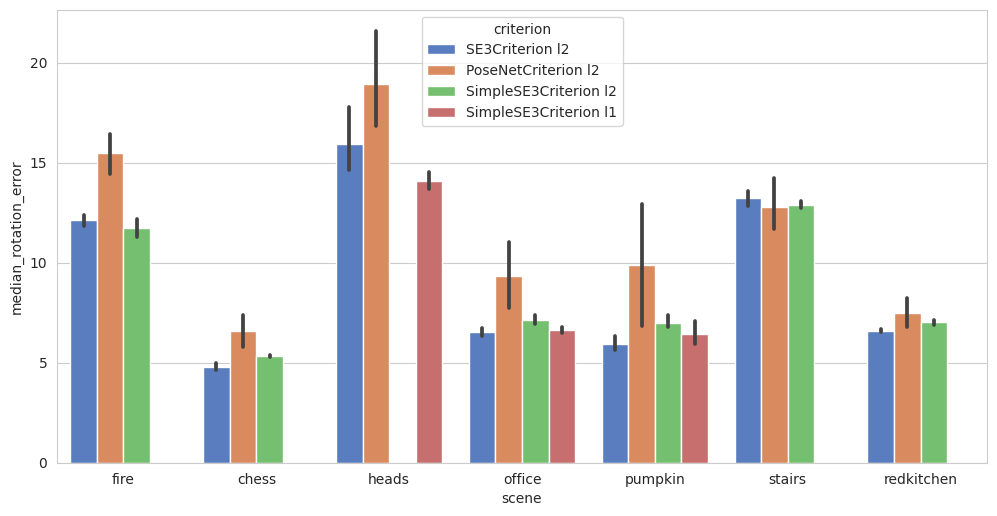

In [22]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.barplot(x="scene", y="median_rotation_error", hue="criterion", data=data_20epoch, ax=ax)

<AxesSubplot:xlabel='scene', ylabel='median_position_error'>

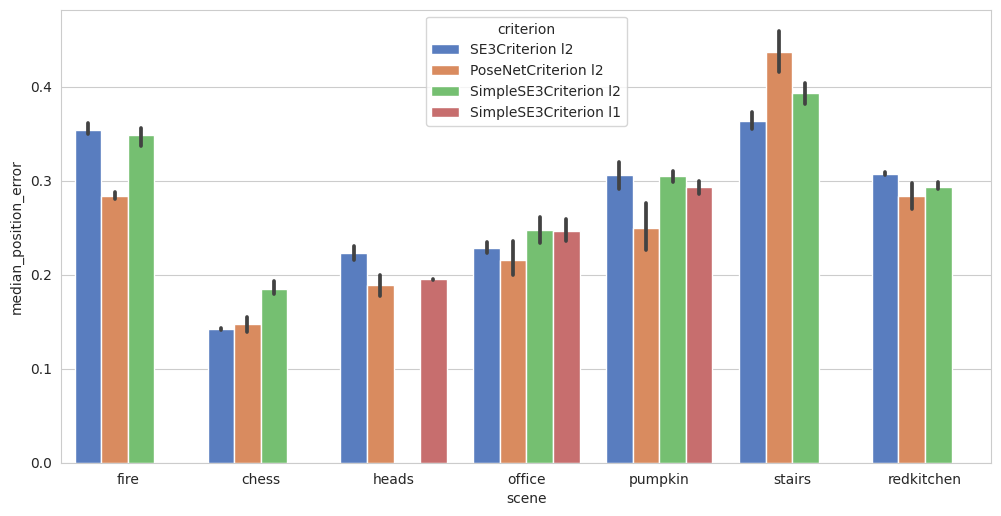

In [23]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.barplot(x="scene", y="median_position_error", hue="criterion", data=data_20epoch, ax=ax)

In [24]:
low_epoch_result_data = data_20epoch.pivot_table(index=["scene"], 
                                         aggfunc=np.mean, 
                                         values=["median_rotation_error", "median_position_error"],
                                         columns=['criterion'])
low_epoch_result_data

median_position_error                                        \
criterion    PoseNetCriterion l2 SE3Criterion l2 SimpleSE3Criterion l1   
scene                                                                    
chess                   0.147678        0.142690                   NaN   
fire                    0.283781        0.354253                   NaN   
heads                   0.188499        0.222607              0.195009   
office                  0.215992        0.228318              0.246260   
pumpkin                 0.249714        0.306203              0.292997   
redkitchen              0.283740        0.307359                   NaN   
stairs                  0.436697        0.363887                   NaN   

                                 median_rotation_error                  \
criterion  SimpleSE3Criterion l2   PoseNetCriterion l2 SE3Criterion l2   
scene                                                                    
chess                   0.184853              6.603564        4.778714   
fire                    0.348439             15.461303       12.127559   
heads                        NaN             18.936376       15.941476   
office                  0.247566              9.326130        6.523015   
pumpkin                 0.304483              9.892162        5.936006   
redkitchen              0.293583              7.488122        6.593758   
stairs                  0.393603             12.798755       13.237672   

                                                        
criterion  SimpleSE3Criterion l1 SimpleSE3Criterion l2  
scene                                                   
chess                        NaN              5.335880  
fire                         NaN             11.750625  
heads                  14.096357                   NaN  
office                  6.614375              7.155588  
pumpkin                 6.443203              7.001481  
redkitchen                   NaN              7.017667  
stairs                       NaN             12.894616

In [25]:
result_data = data_20epoch.pivot_table(index=["scene", "criterion"], 
                                         aggfunc=np.mean, 
                                         values=["median_rotation_error", "median_position_error"])
result_data.pivot_table(index=["criterion"])

,median_position_error,median_rotation_error
criterion,,
PoseNetCriterion l2,0.258015,11.500916
SE3Criterion l2,0.275045,9.305457
SimpleSE3Criterion l1,0.244755,9.051312
SimpleSE3Criterion l2,0.295421,8.525976


## 100 epochs

<AxesSubplot:xlabel='scene', ylabel='median_rotation_error'>

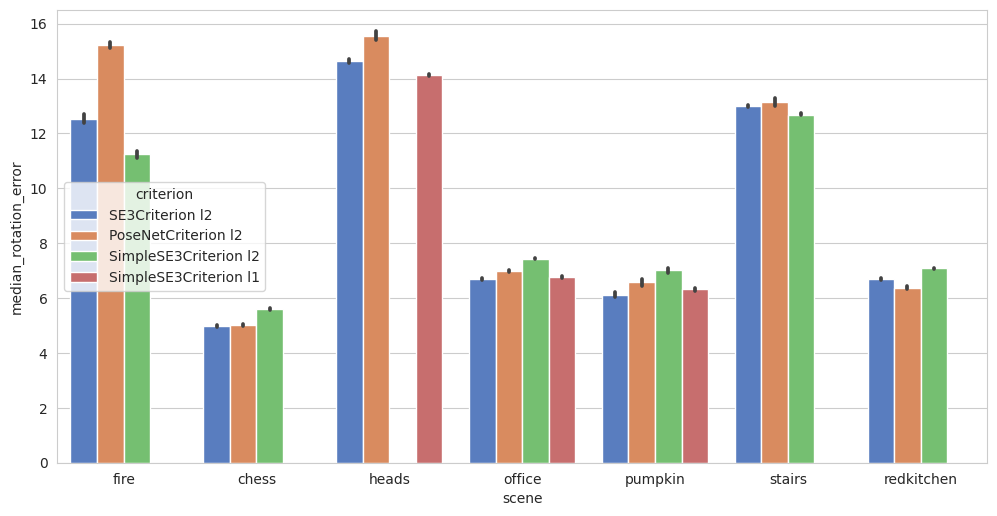

In [26]:
data = experiment_data[experiment_data["epoch"] > 80]
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.barplot(x="scene", y="median_rotation_error", hue="criterion", data=data, ax=ax)

<AxesSubplot:xlabel='scene', ylabel='median_position_error'>

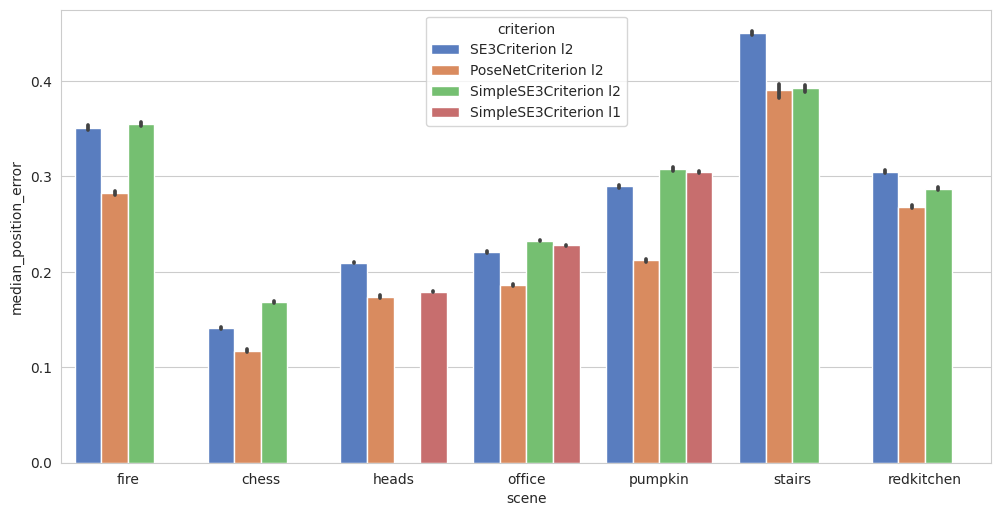

In [27]:
data = experiment_data[experiment_data["epoch"] > 80]
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.barplot(x="scene", y="median_position_error", hue="criterion", data=data, ax=ax)

In [28]:
data = experiment_data[experiment_data["epoch"] > 80]
result_data = data.pivot_table(index=["scene", "criterion"], aggfunc=np.mean, values=["median_rotation_error", 
                                                                       "median_position_error"])
result_data
# data = data.applymap(lambda x: np.round(x, 3))

median_position_error  median_rotation_error
scene      criterion                                                          
chess      PoseNetCriterion l2                 0.117377               5.010873
           SE3Criterion l2                     0.140976               4.969876
           SimpleSE3Criterion l2               0.168243               5.604388
fire       PoseNetCriterion l2                 0.282200              15.216749
           SE3Criterion l2                     0.350969              12.539901
           SimpleSE3Criterion l2               0.354602              11.241355
heads      PoseNetCriterion l2                 0.173814              15.565928
           SE3Criterion l2                     0.209621              14.635906
           SimpleSE3Criterion l1               0.179202              14.119820
office     PoseNetCriterion l2                 0.185890               6.992270
           SE3Criterion l2                     0.220744               6.689986
           SimpleSE3Criterion l1               0.227827               6.762346
           SimpleSE3Criterion l2               0.232601               7.438024
pumpkin    PoseNetCriterion l2                 0.211812               6.567925
           SE3Criterion l2                     0.289402               6.130085
           SimpleSE3Criterion l1               0.304726               6.326115
           SimpleSE3Criterion l2               0.307263               7.010899
redkitchen PoseNetCriterion l2                 0.268019               6.384517
           SE3Criterion l2                     0.304935               6.700925
           SimpleSE3Criterion l2               0.286674               7.079985
stairs     PoseNetCriterion l2                 0.390284              13.151490
           SE3Criterion l2                     0.450023              13.008915
           SimpleSE3Criterion l2               0.392402              12.687002

In [29]:
result_data.pivot_table(index=["criterion"])

,median_position_error,median_rotation_error
criterion,,
PoseNetCriterion l2,0.232771,9.841393
SE3Criterion l2,0.280953,9.239371
SimpleSE3Criterion l1,0.237252,9.069427
SimpleSE3Criterion l2,0.290298,8.510276
